# RNN-王泓杰

# 1.导入相关包
加载并预处理你的数据：

In [9]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report

# 2.数据处理

In [10]:

data = pd.read_csv(R'data.csv')


label_encoder = LabelEncoder()
data['diagnosis'] = label_encoder.fit_transform(data['diagnosis'])

# 分离特征和标签
X = data.drop('diagnosis', axis=1).values
y = data['diagnosis'].values

# 标准化特征
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将数据转换为张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 创建DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 3.RNN模型的构建
    此处是一个单层的RNN，隐藏层大小为128，输出经过一个大小为2的全连接层，以此来实现二分类任务

In [11]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_size = X_train.shape[1]
hidden_size = 128
output_size = 2
num_layers = 1

model = RNNModel(input_size, hidden_size, output_size, num_layers)


# 4.模型训练


In [12]:
# 超参数
num_epochs = 20
learning_rate = 0.001

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.view(inputs.size(0), 1, -1)  # 调整输入形状以适应RNN
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.view(inputs.size(0), 1, -1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
    
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1/20, Train Loss: 0.4985, Test Loss: 0.2559
Epoch 2/20, Train Loss: 0.2176, Test Loss: 0.1334
Epoch 3/20, Train Loss: 0.1392, Test Loss: 0.0953
Epoch 4/20, Train Loss: 0.1077, Test Loss: 0.0792
Epoch 5/20, Train Loss: 0.0935, Test Loss: 0.0720
Epoch 6/20, Train Loss: 0.0836, Test Loss: 0.0671
Epoch 7/20, Train Loss: 0.0781, Test Loss: 0.0632
Epoch 8/20, Train Loss: 0.0731, Test Loss: 0.0636
Epoch 9/20, Train Loss: 0.0700, Test Loss: 0.0623
Epoch 10/20, Train Loss: 0.0669, Test Loss: 0.0587
Epoch 11/20, Train Loss: 0.0651, Test Loss: 0.0578
Epoch 12/20, Train Loss: 0.0630, Test Loss: 0.0565
Epoch 13/20, Train Loss: 0.0616, Test Loss: 0.0571
Epoch 14/20, Train Loss: 0.0596, Test Loss: 0.0562
Epoch 15/20, Train Loss: 0.0592, Test Loss: 0.0548
Epoch 16/20, Train Loss: 0.0576, Test Loss: 0.0553
Epoch 17/20, Train Loss: 0.0564, Test Loss: 0.0562
Epoch 18/20, Train Loss: 0.0557, Test Loss: 0.0548
Epoch 19/20, Train Loss: 0.0542, Test Loss: 0.0552
Epoch 20/20, Train Loss: 0.0536, Test Lo

# 5.模型评估与训练结果

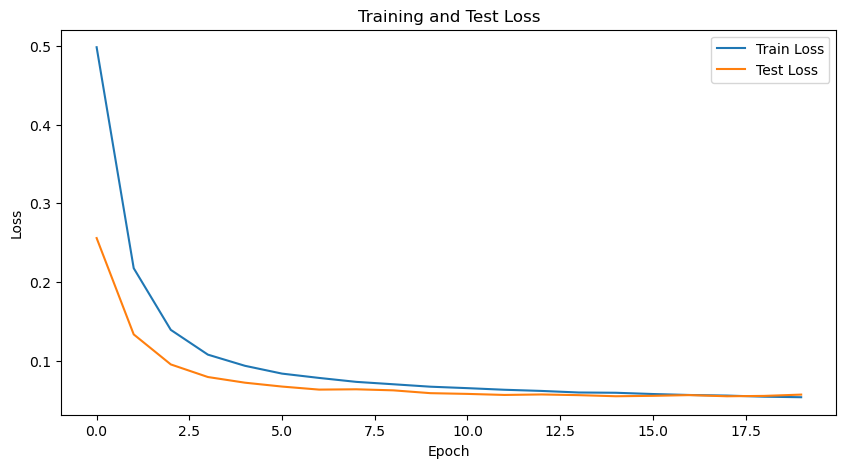

Accuracy: 0.9825
Classification Report:
              precision    recall  f1-score   support

           B       0.99      0.99      0.99        71
           M       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [14]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体渲染问题
plt.rcParams['axes.unicode_minus'] = False    # '-'号问题
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN loss - 王泓杰')
plt.legend()
plt.show()

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(inputs.size(0), 1, -1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


# SVM-保振飞

## 0.硬件加速模块导入
    在进行网格搜索的时候，发现速度比较慢，查阅资料后发现，由于sklearn本身的SVC可能并不一定有硬件加速，同时Intel本身对Sklearn的部分模型有硬件加速扩展，故导入相关库，来进行硬件加速

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

## 1. 数据加载与预处理
    本模块负责从CSV文件中加载数据，并进行初步的预处理。这包括移除无关的列（如ID列），分离特征和标签，并将标签转换为适合模型处理的格式（例如，将文本标签转换为数值标签）。

In [6]:
#导入相关库
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
# 加载数据
data = pd.read_csv(R'data.csv', sep=',')
data.drop('id', axis=1, inplace=True)

# 假设所有列（除了'diagnosis'列）都是特征
features = data.drop('diagnosis', axis=1)
labels = data['diagnosis']

# 将标签转换为二进制形式（例如，Malignant为1，Benign为0）
labels = labels.map({'M': 1, 'B': 0})

## 2. 数据划分与标准化
    此模块将数据集划分为训练集和测试集，并对特征数据进行标准化处理，以确保模型训练的稳定性和有效性。

In [7]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 3. 模型定义与超参数搜索
    定义支持向量机（SVM）模型，最开始直接调用fit后，发现模型在测试集上的表现并没有很高。查阅资料后得知，SVM可以指定相关的超参数来进行模型调优。于是使用网格搜索，来遍所有可能的超参数组合，以此来提高准确度。在进行了网格搜索之后，准确度上升到了98%

In [9]:
# 创建SVM模型
model = SVC(random_state=42)

# 定义超参数网格
param_grid = {
    'C': np.logspace(-2, 2, num=100),
    'gamma': np.logspace(-2, 2, num=10),
    'kernel': ['linear', 'rbf']
}

# 创建GridSearchCV对象
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=8)

# 执行网格搜索
grid_search.fit(X_train, y_train)

## 4. 模型训练与评估
    在确定了最佳的超参数之后，还需要重新用该参数训练，并在测试集上进行预测，评估模型的准确度和混淆矩阵。

In [10]:
# 输出最佳参数
print("Best Parameters: ", grid_search.best_params_)

# 使用最佳参数重新训练模型
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# 预测
y_pred = best_model.predict(X_test)

# 评估模型
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

Best Parameters:  {'C': 2.2051307399030455, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.9824561403508771
Confusion Matrix:
[[71  0]
 [ 2 41]]


# 逻辑回归-刘建龙

In [ ]:
import pandas as pd  
import torch  
import numpy as np  
import torch.nn as nn  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler  

# 威斯康辛州乳腺癌数据集分类
## 数据集预处理
首先，我们使用 pandas 对数据集合进行加载。可以看到该数据集合一共有 569 条数据，每条数据有 30 个和乳腺癌相关的病变特征，我们可以利用 pandas 中的切片，
先将上表中的特征和标签分开可以看到共有 569 条数据，每条数据有 30 个特征和 1 个标签。按照 0.8 和 0.2 的比例随机划分数据集合  
df = pd.read_csv(  
    'https://labfile.oss.aliyuncs.com/courses/2534/breast_cancer.csv', index_col=False)  
X = df[df.columns[0:-1]].values  
y = df[df.columns[-1]].values   
X.shape, y.shape  
X_train, X_test, y_train, y_test = train_test_split(  
    X, y, test_size=0.2, random_state=1234)  
X_train.shape, y_train.shape, X_test.shape, y_test.shape  

## 数据集的划分和标准化
为了能够评价模型的好坏，这里我们利用 sklearn.model_selection 函数，将原数据按比例随机分为训练数据集和测试数据集。为了加快模型的收敛速度，
一般我们都需要对原始数据进行标准化处理，将所有的数据按照比例缩放到一定范围内。这里我们可以使用 sklearn.preprocessing 来对数据集合进行标准化。
最后，为了将数据放入 PyTorch 定义的模型之中，我们必须将所有的数据转为张量类型。将标签也转为 2 维，否则放入模型之中训练时，可能出错（因为标签原
本只有一列，每一行就一个数，现在要变为二维（标签的第二维为1），和x匹配）
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)        
X_train = torch.from_numpy(X_train.astype(np.float32))  
X_test = torch.from_numpy(X_test.astype(np.float32))  
y_train = torch.from_numpy(y_train.astype(np.float32))  
y_test = torch.from_numpy(y_test.astype(np.float32))  
y_train = y_train.view(y_train.shape[0], 1)  
y_test = y_test.view(y_test.shape[0], 1)  
X_train.size(), y_train.size()  

## 模型的定义
处理完数据后，我们还需要建立相应的模型，用于乳腺癌的预测我们的模型是一个线性函数+激活函数的非线性模型。线性函数是一条没有上界和下界的直线，
即线性函数预测出来的值可以很大如 112321442，也可以很小如 -1231242412。而本实验的数据标签只有 0（患病） 或 1（不患病），因此用线性函数来拟合乳腺癌的数据点是不合理的。
我们需要找到输出始终为 0-1 之间的函数模型。如果拥有这样的函数模型，那么将任意 x 放入该模型中，都会输出一个 0-1 之间的值。这个值我们可以看做是患有乳腺癌的概率，
如果这个概率值小于 0.5 则表示没有患乳腺癌。如果这个概率值大于 0.5 则表示患有乳腺癌。逻辑回归函数 Sigmoid 就是这样一种函数，该函数又叫做激活函数。
该函数是一个上下界分别为 1 和 0 的有界非线性函数。我们可以让通过了线性函数的输出，再通过一次上面的激活函数，进而得到 0-1 之间的结果。
至此，我们就得到了一个乳腺癌的初始模型。由于最后通过了一层逻辑回归函数，无论输入的值为多少，模型的输出都必定属于 0-1 之间。
class Model(nn.Module):  
    def __init__(self, n_input_features):  
        super(Model, self).__init__()  
        self.linear = nn.Linear(n_input_features, 1)  

    def forward(self, x):  
        y_pred = torch.sigmoid(self.linear(x))  
        return y_pred  
n_samples, n_features = X.shape  
model = Model(n_features)  

## 损失和优化器的定义
定义一下损失函数，由于我们的标签只有 0 和 1，因此这里使用二元交叉熵损失nn.BCELoss()来计算真实值和预测值之间的距离了。L=−∑Ni=1yilogy^i+(1−yi)log(1−y^i)
当然，我们不必手写上面的损失函数， 直接使用 nn.BCELoss() 即可
num_epochs = 100  
learning_rate = 0.01  
criterion = nn.BCELoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

## 模型的训练
定义完损失函数和优化器后，接下来的模型训练步骤就是固定的了，如下：  
*通过模型的正向传播，输出预测结果。*  
*通过预测结果和真实标签计算损失。*  
*通过后向传播，获得梯度。*  
*通过梯度更新模型的权重。*  
*进行梯度的清空。*  
*循环上面操作，直到损失较小为止。*  
for epoch in range(num_epochs):  
    y_pred = model(X_train)  
    loss = criterion(y_pred, y_train)  
    loss.backward()  
    optimizer.step()  
    optimizer.zero_grad()  

    if (epoch + 1) % 10 == 0:  
        print(f'epoch: {epoch + 1}, loss = {loss.item():.4f}')  
print("模型训练完毕！！")  

## 模型演示
随机取一组数据进行预算，然后输出预测值与真实值进行对比
index = np.random.randint(0, len(X_test))   
y_predicted = model(X_test[index])  
y_predicted_cls = y_predicted.round()  

real = y_test[index].detach().numpy()[0]  
predict = y_predicted_cls.detach().numpy()[0]  
print("第 {} 条测试数据的真实结果为 {} ，预测结果为 {} "  
      .format(index, real, predict))  

with torch.no_grad():  
    y_predicted = model(X_test)  
    y_predicted_cls = y_predicted.round()  
    acc = y_predicted_cls.eq(y_test).sum().numpy() / float(y_test.shape[0])  
    #  y_predicted_cls.eq(y_test).sum()   
    print(f'accuracy: {acc.item():.4f}')  

# 逻辑回归-王熙择

In [32]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from plotly.offline import iplot, plot
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.preprocessing import StandardScaler

首先导入所有可能会用到的包

In [33]:
df = pd.read_csv(R'data.csv')
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


### 然后观察数据
#### 第一 我们能发现数据中含有字母,所以我们要将M和B转化为1和0 
#### 其次 我们能发现数据中的最后一列是需要删除的

In [34]:
df.drop(columns=['id','Unnamed: 32'],inplace=True)
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


删除最后一列数据

In [35]:
df.replace('M','0',inplace = True)
df.replace('B','1',inplace = True)
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,0,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,0,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,0,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


将M替换为0,将N替换为1

In [36]:
X = df.drop(['diagnosis'] , axis=1)
X

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


将去除了标签的数据存入X

In [37]:
y = df[df.columns[0]].values
y

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '1', '1',
       '1', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '1', '0',
       '0', '1', '1', '1', '1', '0', '1', '0', '0', '1', '0', '1', '0',
       '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '1', '1',
       '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '1', '1', '1',
       '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1',
       '0', '0', '0', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0',
       '1', '0', '0', '1', '0', '0', '1', '1', '0', '1', '1', '0', '1',
       '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '0', '1', '1', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0',
       '1', '1', '0', '0', '1', '1', '1', '1', '0', '1', '1', '0

将去标签的数据存入y

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=7348)
sc = StandardScaler()  # 对特征进行标准化，标签不要标准化，因为标签只有 0 和 1
X_train = sc.fit_transform(X_train)  # fit_transform对训练集进行标准化
X_test = sc.transform(X_test)  # transform对测试集进行标准化


X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))
y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)
X_train,X_test

(tensor([[ 0.1700, -1.2286,  0.2687,  ..., -0.0522, -0.1144,  0.4700],
         [-0.7952,  1.8808, -0.8308,  ..., -1.4280, -0.0788, -0.7222],
         [ 0.1957,  1.1355,  0.2347,  ...,  0.7215,  0.6852,  0.3030],
         ...,
         [-1.8345,  1.4915, -1.8040,  ..., -0.9819, -0.1743,  1.2861],
         [-0.9155, -1.4707, -0.9584,  ..., -1.1420, -0.2584, -0.3861],
         [-0.4687,  1.1592, -0.3234,  ...,  1.6328,  2.3768,  6.9572]]),
 tensor([[-1.6833,  0.3664, -1.5991,  ..., -0.5417,  0.6869,  3.6467],
         [-0.6835, -0.8797, -0.6949,  ..., -0.5440, -0.2147, -0.3180],
         [-0.1393,  1.3135, -0.1659,  ...,  0.2857,  0.9264, -0.2652],
         ...,
         [-0.1451,  0.6370, -0.1908,  ..., -0.8001, -0.7311, -0.7576],
         [-0.8439, -1.4423, -0.8678,  ..., -0.9045, -0.0626, -0.8992],
         [-0.8954, -0.4643, -0.8320,  ...,  0.6313, -0.5789,  0.6521]]))

1. 划分训练集和测试集
2. 将数据进行标准化处理
3. 将数据放入模型中

In [40]:
class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)  # 参数：输入神经元的个数和输出神经元的个数

    def forward(self, x):
        # torch 中已经定义了 sigmoid 函数模型
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
 
n_samples, n_features = X.shape
# 模型的初始化
model = Model(n_features)
model

Model(
  (linear): Linear(in_features=30, out_features=1, bias=True)
)

创建预测模型

In [41]:
um_epochs = 100
# 学习率
learning_rate = 0.01
# 二元交叉熵损失
criterion = nn.BCELoss()
# SGD 优化器
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion, optimizer

(BCELoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

创建损失函数和优化器

In [43]:
loss_values = []
for epoch in range(num_epochs):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss_values.append(loss.item())
    # 后向传播、梯度更新、梯度清空
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if (epoch + 1) % 10 == 0:
        print(f'epoch: {epoch + 1}, loss = {loss.item():.4f}')
print("模型训练完毕！！")


epoch: 10, loss = 0.5447
epoch: 20, loss = 0.4644
epoch: 30, loss = 0.4106
epoch: 40, loss = 0.3717
epoch: 50, loss = 0.3421
epoch: 60, loss = 0.3186
epoch: 70, loss = 0.2994
epoch: 80, loss = 0.2834
epoch: 90, loss = 0.2697
epoch: 100, loss = 0.2579
模型训练完毕！！


训练模型

In [44]:
accuracy_values=[]
with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum().numpy() / float(y_test.shape[0])
    accuracy_values.append(acc)
    #  y_predicted_cls.eq(y_test).sum() # 测试值与预测值相同的样本总数
    print(f'accuracy: {acc.item():.4f}')


accuracy: 0.9474


输出模型的准确率

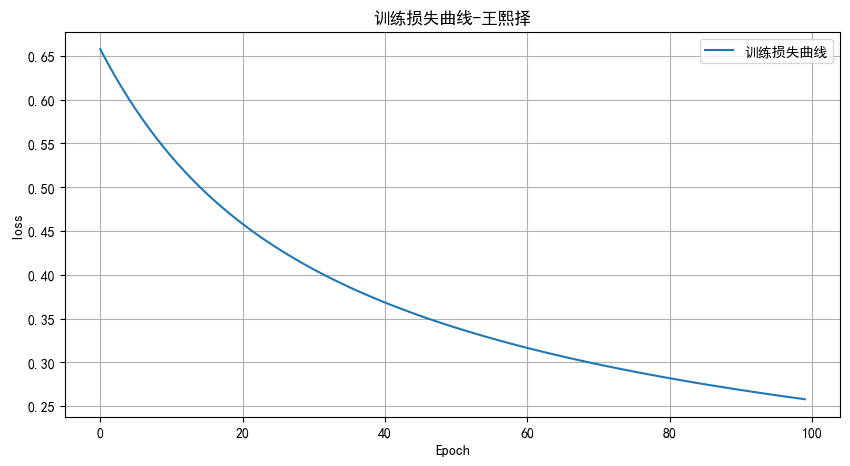

In [50]:
plt.figure(figsize=(10, 5))
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
plt.plot(loss_values, label='训练损失曲线')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('训练损失曲线-王熙择')
plt.legend()
plt.grid(True)
plt.show()

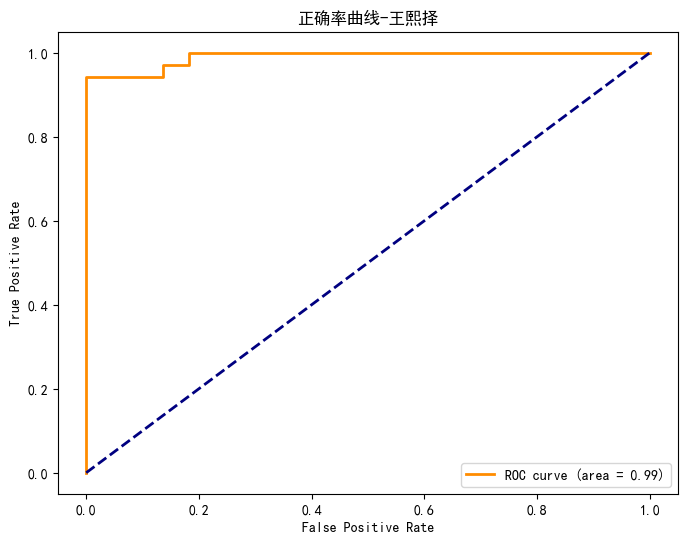

In [51]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('正确率曲线-王熙择')
plt.legend(loc="lower right")
plt.show()

# 随机森林-叶旺洋

## 数据导入

In [2]:
import numpy as np
import pandas as pd
dataset = pd.read_csv(R'dara.csv', header=0,
                      usecols = range(0, 32, 1))

ValueError: Usecols do not match columns, columns expected but not found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

## 数据展示

In [ ]:
from sklearn import preprocessing
from collections import Counter
encoder = preprocessing.LabelEncoder().fit(dataset['diagnosis'])
dataset['diagnosis'] = encoder.transform(dataset['diagnosis'])
print('标签: %s' % encoder.classes_)
print('标签值标准化: %s' % encoder.transform(['benign', 'malignant']))
X = np.array(dataset)
dataset_target = X[:, 1]
dataset_data = X[:, 2:32]
print(Counter(dataset_target))

标签: ['benign' 'malignant']
标签值标准化: [0 1]
Counter({0.0: 357, 1.0: 212})


## 数据均衡：SMOTEENN

In [ ]:
from imblearn.combine import SMOTEENN
smo = SMOTEENN()
dataset_data_sm, dataset_target_sm = smo.fit_resample(dataset_data, dataset_target)
Counter(dataset_target_sm)

Counter({0.0: 315, 1.0: 306})

## 数据标准化

In [ ]:
from sklearn import preprocessing
import numpy as np
dataset_data_scaled = preprocessing.scale(dataset_data_sm)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from xgboost import plot_importance
# features and lanbels
X = dataset_data_scaled
Y = dataset_target_sm
# split data into train and test set
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state=90)
#fit modle on training data
model = RandomForestClassifier(random_state=90, max_depth=9, n_estimators=66, max_features=29, criterion="gini")
model.fit(X_train, y_train)
# make predictions on test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred] # float -> integer
#evaluate
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 95.80%


## 展示特征重要性

Feature Ranking
(1) concave points_worst  0.336391
(2) concave points_mean  0.262382
(3) perimeter_worst  0.191281
(4) area_worst  0.028797
(5) concavity_worst  0.026790
(6) radius_worst  0.023541
(7) area_se  0.022545
(8) texture_mean  0.019691
(9) texture_worst  0.016347
(10) smoothness_worst  0.010052


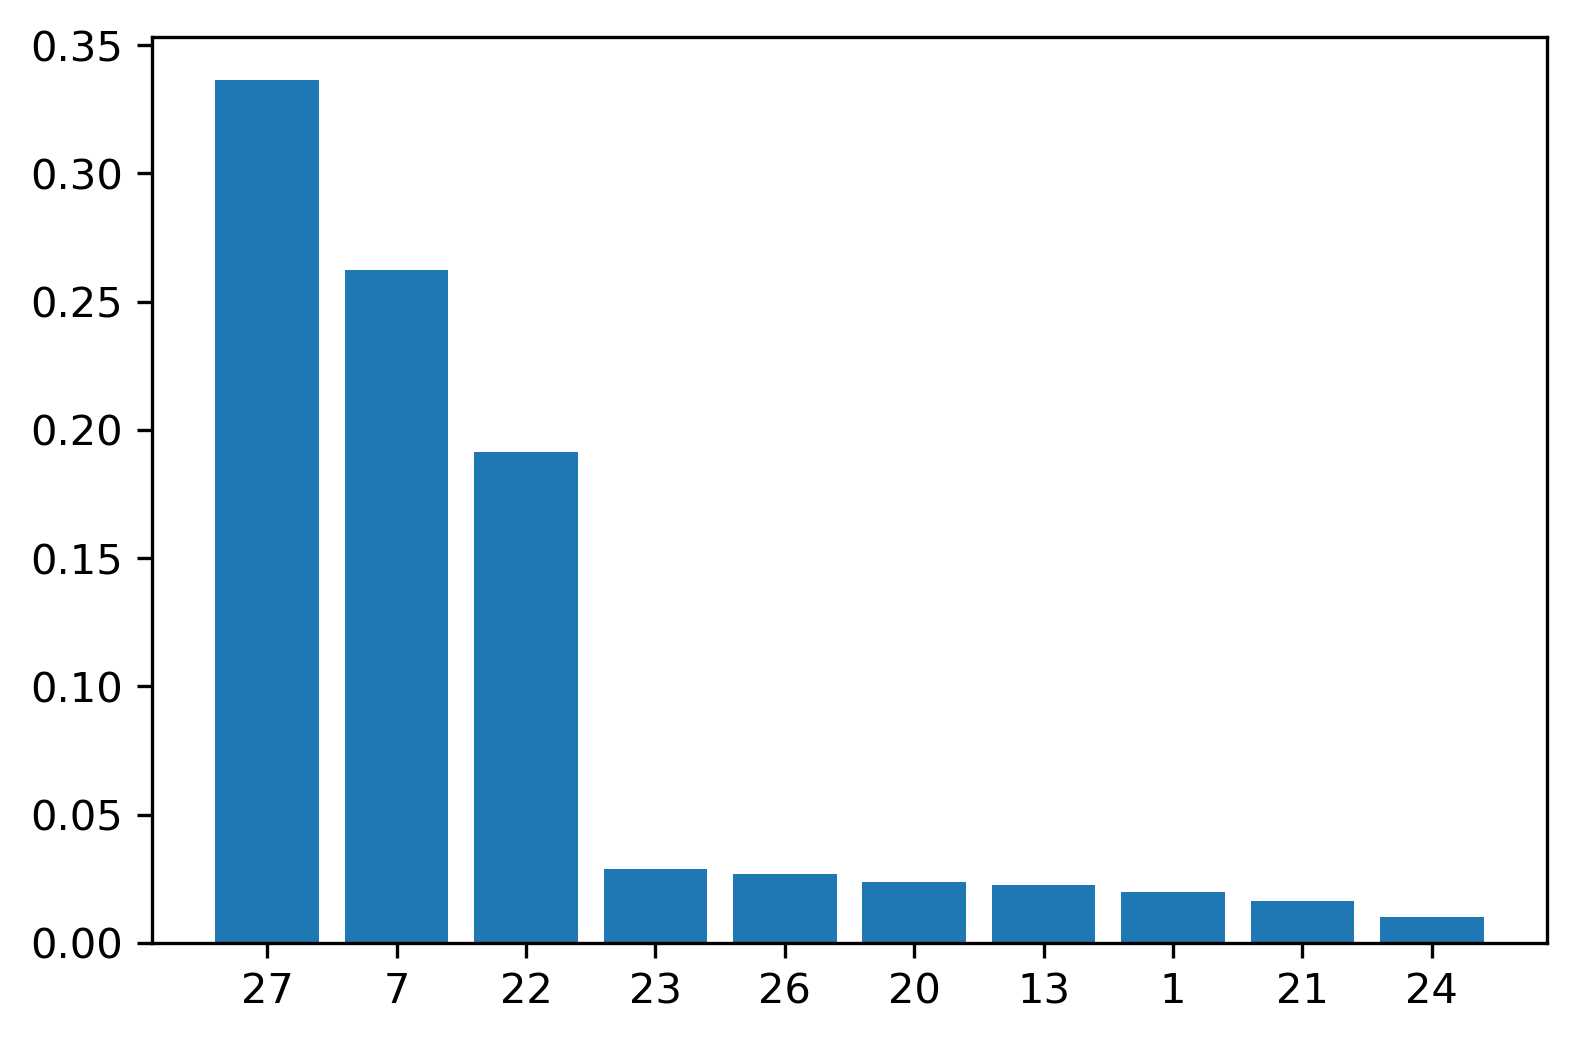

In [ ]:
# the importance of each feature
import matplotlib.pyplot as plt
importances = model.feature_importances_
# sort
index = np.argsort(importances)[::-1]
print("Feature Ranking")
for i in range(0, 10):
    print("(%d) %s  %f" % (i+1, dataset.columns[index[i]+2], importances[index[i]]))
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.bar(range(10), importances[index][0:10])
plt.xticks(range(10), index)
plt.savefig(r'C:\Users\Alchemist\Documents\myProject\ppt\pictures\RandomForest\imp.png')

others  0.072233
concave points_worst  0.336391
concave points_mean  0.262382
perimeter_worst  0.191281
area_worst  0.028797
concavity_worst  0.026790
radius_worst  0.023541
area_se  0.022545
texture_mean  0.019691
texture_worst  0.016347


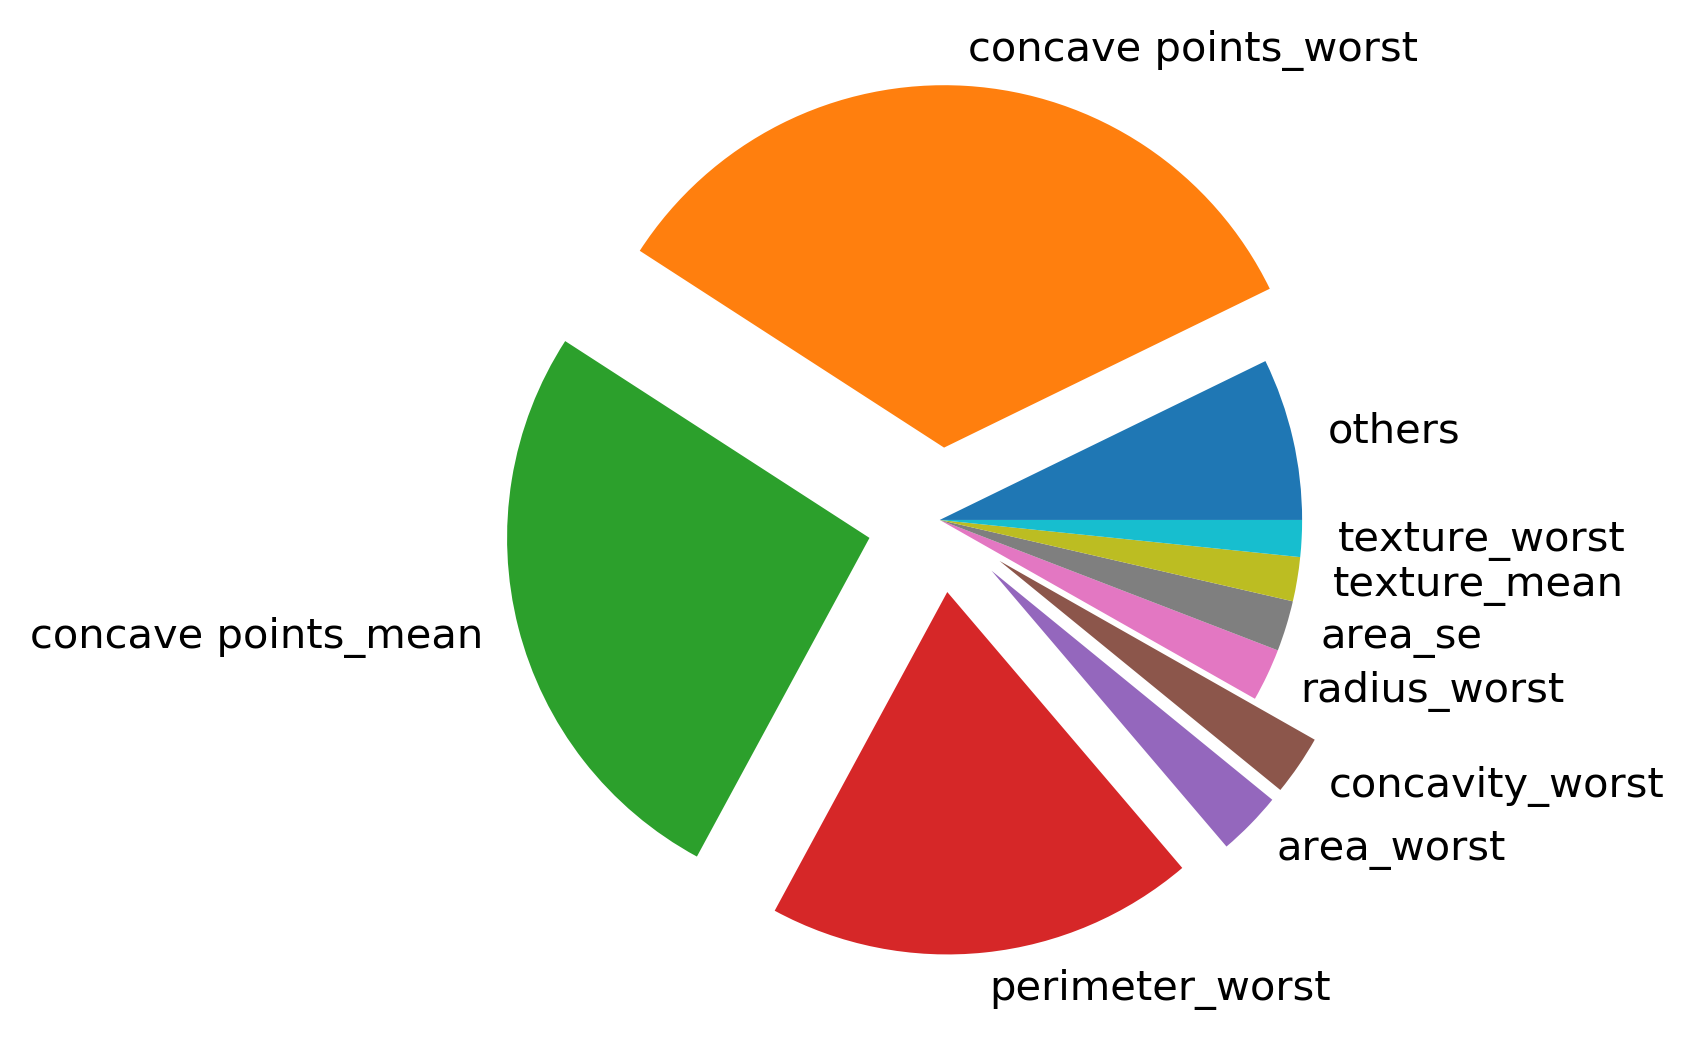

In [ ]:
labels = ["others"]
values = [0]
explode = [0]
for i in range(0, 30):
    #print("(%d) %s  %f" % (index[i], dataset.columns[index[i]+2], importances[index[i]]))
    if i < 9:
        labels.append(dataset.columns[index[i]+2])
        values.append(importances[index[i]])
        if i < 5:
            explode.append(0.2)
        else:
            explode.append(0)
    else:
        values[0] = values[0] + importances[index[i]]
for i in range(10):
    print("%s  %f" % (labels[i], values[i]))
#plt.bar(range(11), values)
plt.pie(values,labels=labels, explode=explode)
plt.savefig(r"C:\Users\Alchemist\Documents\myProject\ppt\pictures\RandomForest\pie.png")

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
Estimators = model.estimators_[0:5]
for index, submodel in enumerate(Estimators):
    filename = 'iris_' + str(index) + '.pdf'
    dot_data = export_graphviz(submodel , out_file=None,
                         feature_names=dataset.columns[2:32],
                         class_names=['benign', 'malignant'],
                         filled=True, rounded=True,
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    # 使用ipython的终端jupyter notebook显示。
    Image(graph.create_png())
    graph.write_pdf(r"C:\Users\Alchemist\Documents\myProject\ppt\pictures\RandomForest\sub_tree.pdf")

In [ ]:
Estimators = model.estimators_[0:5]
Estimators

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=9, max_features=29, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=657362779, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=9, max_features=29, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1371179677, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=9, max_features=29, m

## 单个决策树对照

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 2, criterion = 'entropy')
clf.fit(X_train, y_train)
ans = clf.predict(X_test)
predictions = [(value) for value in ans] # float -> integer

accuracy = accuracy_score(y_test, predictions)
cnt = 0
for i in range(len(y_test)):
    if abs(ans[i] - y_test[i]) < 1e-1:
        cnt += 1
    c = (cnt / len(y_test))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.51%


## 折线图 n_estimators, max_depth

In [ ]:
from sklearn.model_selection import train_test_split

def Get_Average(list):
    sum = 0
    for num in list:
        sum += num
    avg = sum / len(list)
    return avg

accuracy = []
max_depth_test = np.arange(2, 11)
estimators_test = np.arange(2, 200, 2)
max_accuracy, best_depth, best_estimators_num = (0.0, 2, 2)
for depth in max_depth_test:
    for estimators in estimators_test:
        current = []
        for r in range(5):
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = r)
            clf = RandomForestClassifier(n_estimators=estimators, max_depth=depth, n_jobs=-1, 
                                        criterion="gini")
            clf.fit(X_train, y_train)
            ans = clf.predict(X_test)
            cnt = 0
            for i in range(len(y_test)):
                if ans[i] == y_test[i]:
                    cnt += 1
            c = cnt / len(y_test)
            current.append(c)
        avg = Get_Average(current)
        if avg > max_accuracy:
            max_accuracy = avg
            best_depth = depth
            best_estimators_num = estimators
        accuracy.append(avg)
        print("max_depth = %d  n_estimators = %d  accuracy = %f%%" % (depth, estimators, avg*100))

max_depth = 2  n_estimators = 2  accuracy = 93.146853%
max_depth = 2  n_estimators = 4  accuracy = 93.846154%
max_depth = 2  n_estimators = 6  accuracy = 93.146853%
max_depth = 2  n_estimators = 8  accuracy = 93.986014%
max_depth = 2  n_estimators = 10  accuracy = 93.986014%
max_depth = 2  n_estimators = 12  accuracy = 92.867133%
max_depth = 2  n_estimators = 14  accuracy = 93.566434%
max_depth = 2  n_estimators = 16  accuracy = 94.545455%
max_depth = 2  n_estimators = 18  accuracy = 93.986014%
max_depth = 2  n_estimators = 20  accuracy = 94.125874%
max_depth = 2  n_estimators = 22  accuracy = 94.125874%
max_depth = 2  n_estimators = 24  accuracy = 94.265734%
max_depth = 2  n_estimators = 26  accuracy = 94.265734%
max_depth = 2  n_estimators = 28  accuracy = 94.685315%
max_depth = 2  n_estimators = 30  accuracy = 93.986014%
max_depth = 2  n_estimators = 32  accuracy = 93.846154%
max_depth = 2  n_estimators = 34  accuracy = 93.706294%
max_depth = 2  n_estimators = 36  accuracy = 93.9860

max_depth = 3  n_estimators = 96  accuracy = 95.384615%
max_depth = 3  n_estimators = 98  accuracy = 94.825175%
max_depth = 3  n_estimators = 100  accuracy = 94.965035%
max_depth = 3  n_estimators = 102  accuracy = 95.104895%
max_depth = 3  n_estimators = 104  accuracy = 94.825175%
max_depth = 3  n_estimators = 106  accuracy = 94.965035%
max_depth = 3  n_estimators = 108  accuracy = 94.965035%
max_depth = 3  n_estimators = 110  accuracy = 95.104895%
max_depth = 3  n_estimators = 112  accuracy = 94.965035%
max_depth = 3  n_estimators = 114  accuracy = 94.405594%
max_depth = 3  n_estimators = 116  accuracy = 94.825175%
max_depth = 3  n_estimators = 118  accuracy = 95.244755%
max_depth = 3  n_estimators = 120  accuracy = 95.244755%
max_depth = 3  n_estimators = 122  accuracy = 94.685315%
max_depth = 3  n_estimators = 124  accuracy = 95.104895%
max_depth = 3  n_estimators = 126  accuracy = 94.825175%
max_depth = 3  n_estimators = 128  accuracy = 94.825175%
max_depth = 3  n_estimators = 130

max_depth = 4  n_estimators = 188  accuracy = 95.524476%
max_depth = 4  n_estimators = 190  accuracy = 95.384615%
max_depth = 4  n_estimators = 192  accuracy = 95.664336%
max_depth = 4  n_estimators = 194  accuracy = 95.384615%
max_depth = 4  n_estimators = 196  accuracy = 95.664336%
max_depth = 4  n_estimators = 198  accuracy = 95.384615%
max_depth = 5  n_estimators = 2  accuracy = 93.146853%
max_depth = 5  n_estimators = 4  accuracy = 95.244755%
max_depth = 5  n_estimators = 6  accuracy = 94.685315%
max_depth = 5  n_estimators = 8  accuracy = 95.524476%
max_depth = 5  n_estimators = 10  accuracy = 96.363636%
max_depth = 5  n_estimators = 12  accuracy = 96.643357%
max_depth = 5  n_estimators = 14  accuracy = 95.384615%
max_depth = 5  n_estimators = 16  accuracy = 96.363636%
max_depth = 5  n_estimators = 18  accuracy = 95.384615%
max_depth = 5  n_estimators = 20  accuracy = 95.944056%
max_depth = 5  n_estimators = 22  accuracy = 95.944056%
max_depth = 5  n_estimators = 24  accuracy = 9

max_depth = 6  n_estimators = 84  accuracy = 96.083916%
max_depth = 6  n_estimators = 86  accuracy = 96.083916%
max_depth = 6  n_estimators = 88  accuracy = 96.503497%
max_depth = 6  n_estimators = 90  accuracy = 95.944056%
max_depth = 6  n_estimators = 92  accuracy = 96.083916%
max_depth = 6  n_estimators = 94  accuracy = 96.223776%
max_depth = 6  n_estimators = 96  accuracy = 96.223776%
max_depth = 6  n_estimators = 98  accuracy = 96.083916%
max_depth = 6  n_estimators = 100  accuracy = 96.363636%
max_depth = 6  n_estimators = 102  accuracy = 96.083916%
max_depth = 6  n_estimators = 104  accuracy = 96.363636%
max_depth = 6  n_estimators = 106  accuracy = 96.223776%
max_depth = 6  n_estimators = 108  accuracy = 96.503497%
max_depth = 6  n_estimators = 110  accuracy = 95.804196%
max_depth = 6  n_estimators = 112  accuracy = 95.804196%
max_depth = 6  n_estimators = 114  accuracy = 96.223776%
max_depth = 6  n_estimators = 116  accuracy = 95.944056%
max_depth = 6  n_estimators = 118  accu

max_depth = 7  n_estimators = 176  accuracy = 96.083916%
max_depth = 7  n_estimators = 178  accuracy = 96.643357%
max_depth = 7  n_estimators = 180  accuracy = 96.223776%
max_depth = 7  n_estimators = 182  accuracy = 96.363636%
max_depth = 7  n_estimators = 184  accuracy = 96.643357%
max_depth = 7  n_estimators = 186  accuracy = 96.223776%
max_depth = 7  n_estimators = 188  accuracy = 96.503497%
max_depth = 7  n_estimators = 190  accuracy = 96.363636%
max_depth = 7  n_estimators = 192  accuracy = 96.083916%
max_depth = 7  n_estimators = 194  accuracy = 96.083916%
max_depth = 7  n_estimators = 196  accuracy = 96.223776%
max_depth = 7  n_estimators = 198  accuracy = 96.223776%
max_depth = 8  n_estimators = 2  accuracy = 93.426573%
max_depth = 8  n_estimators = 4  accuracy = 96.503497%
max_depth = 8  n_estimators = 6  accuracy = 95.664336%
max_depth = 8  n_estimators = 8  accuracy = 95.664336%
max_depth = 8  n_estimators = 10  accuracy = 96.083916%
max_depth = 8  n_estimators = 12  accura

max_depth = 9  n_estimators = 72  accuracy = 96.643357%
max_depth = 9  n_estimators = 74  accuracy = 96.503497%
max_depth = 9  n_estimators = 76  accuracy = 95.944056%
max_depth = 9  n_estimators = 78  accuracy = 96.643357%
max_depth = 9  n_estimators = 80  accuracy = 95.804196%
max_depth = 9  n_estimators = 82  accuracy = 95.804196%
max_depth = 9  n_estimators = 84  accuracy = 96.363636%
max_depth = 9  n_estimators = 86  accuracy = 96.363636%
max_depth = 9  n_estimators = 88  accuracy = 96.223776%
max_depth = 9  n_estimators = 90  accuracy = 96.643357%
max_depth = 9  n_estimators = 92  accuracy = 96.223776%
max_depth = 9  n_estimators = 94  accuracy = 96.503497%
max_depth = 9  n_estimators = 96  accuracy = 95.804196%
max_depth = 9  n_estimators = 98  accuracy = 96.503497%
max_depth = 9  n_estimators = 100  accuracy = 96.643357%
max_depth = 9  n_estimators = 102  accuracy = 96.223776%
max_depth = 9  n_estimators = 104  accuracy = 96.363636%
max_depth = 9  n_estimators = 106  accuracy =

max_depth = 10  n_estimators = 162  accuracy = 96.363636%
max_depth = 10  n_estimators = 164  accuracy = 96.223776%
max_depth = 10  n_estimators = 166  accuracy = 96.363636%
max_depth = 10  n_estimators = 168  accuracy = 96.083916%
max_depth = 10  n_estimators = 170  accuracy = 96.083916%
max_depth = 10  n_estimators = 172  accuracy = 95.944056%
max_depth = 10  n_estimators = 174  accuracy = 96.083916%
max_depth = 10  n_estimators = 176  accuracy = 96.083916%
max_depth = 10  n_estimators = 178  accuracy = 96.223776%
max_depth = 10  n_estimators = 180  accuracy = 96.083916%
max_depth = 10  n_estimators = 182  accuracy = 96.223776%
max_depth = 10  n_estimators = 184  accuracy = 95.944056%
max_depth = 10  n_estimators = 186  accuracy = 96.223776%
max_depth = 10  n_estimators = 188  accuracy = 96.083916%
max_depth = 10  n_estimators = 190  accuracy = 96.783217%
max_depth = 10  n_estimators = 192  accuracy = 96.503497%
max_depth = 10  n_estimators = 194  accuracy = 96.223776%
max_depth = 10

## 画出折线图

(10, 99)


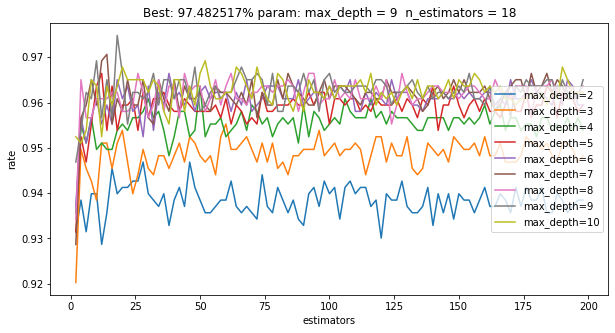

In [ ]:
params_values = np.zeros(len(accuracy)).reshape(len(max_depth_test), len(estimators_test))
print(params_values.shape)
for i in range(len(accuracy)):
    params_values[int(i / len(estimators_test)), int(i % len(estimators_test))] = accuracy[i]
fig = plt.figure(figsize = (10, 5))
for i in range(params_values.shape[0]-1):
    plt.plot(estimators_test, params_values[i], label = "max_depth=" + str(i+2))
plt.xlabel('estimators')
plt.ylabel('rate')
plt.title("Best: %f%% param: max_depth = %d  n_estimators = %d" % (max_accuracy*100, best_depth, best_estimators_num))
plt.legend(loc = 'right')
plt.savefig('C:\\Users\\Alchemist\\Documents\\myProject\\ppt\\pictures\\RandomForest\\polygon1all.png')

## n_estimators大致范围

0.9776212832550861 21


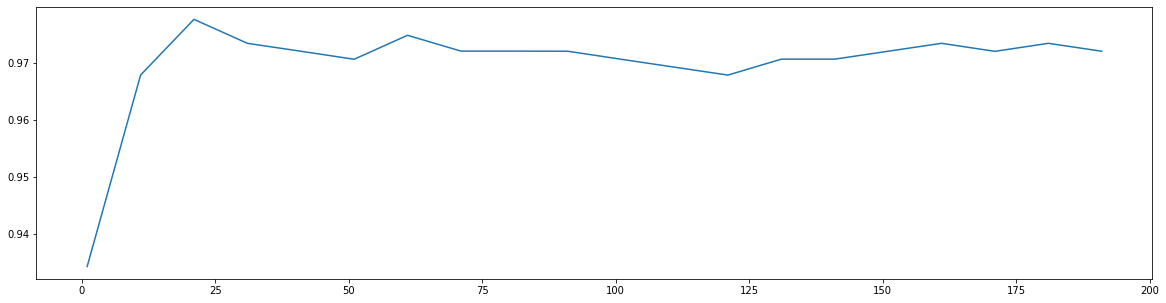

In [ ]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
scorel = []
for i in range(0,200,10):
    clf = RandomForestClassifier(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(clf,X,Y,cv=10).mean()#十折交叉验证取平均
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.savefig(r'C:\Users\Alchemist\Documents\myProject\ppt\pictures\xgboost\n_est1.png')
plt.show()

0.9776408450704224 66


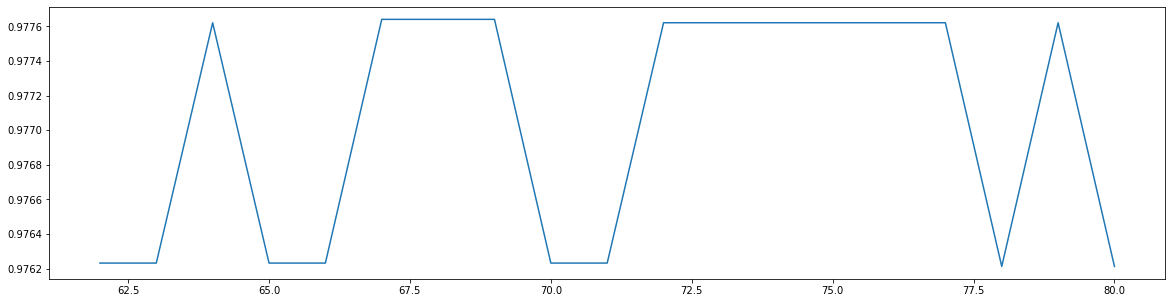

In [ ]:
scorel = []
for i in range(62,81,1):
    clf = RandomForestClassifier(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(clf,X,Y,cv=10).mean()#十折交叉验证取平均
    scorel.append(score)
print(max(scorel),scorel.index(max(scorel))+61)
plt.figure(figsize=[20,5])
plt.plot(range(62,81),scorel)
plt.savefig(r'C:\Users\Alchemist\Documents\myProject\ppt\pictures\xgboost\n_est2.png')
plt.show()

0.9762323943661972 11


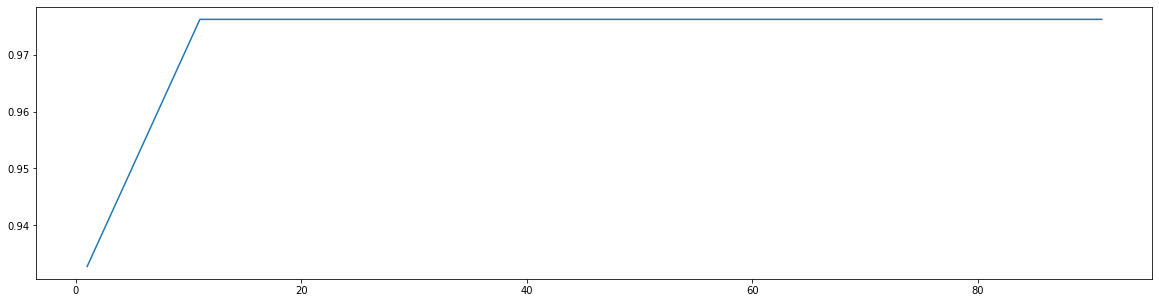

In [ ]:
scorel = []
for i in range(0,100,10):
    clf = RandomForestClassifier(max_depth=i+1,
                                 n_jobs=-1, n_estimators=66,
                                 random_state=90)
    score = cross_val_score(clf,X,Y,cv=10).mean()#十折交叉验证取平均
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,100, 10),scorel)
plt.show()

0.9776408450704224 9


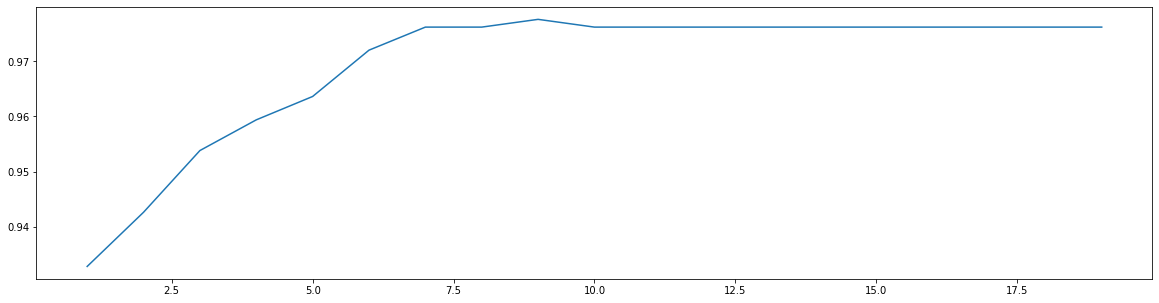

In [ ]:
scorel = []
for i in range(1,20,1):
    clf = RandomForestClassifier(max_depth=i,
                                 n_jobs=-1,n_estimators=66,
                                 random_state=90)
    score = cross_val_score(clf,X,Y,cv=10).mean()#十折交叉验证取平均
    scorel.append(score)
print(max(scorel),scorel.index(max(scorel))+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,20),scorel)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np
clf = RandomForestClassifier(random_state=90, max_depth=9, n_estimators=18)
param_grid = {"criterion" : ["gini", "entropy"],
             "max_features" : np.arange(2, 30)}
gscv = GridSearchCV(clf,param_grid,cv=10)#网格搜索
gscv.fit(X, Y)
print("Best: %f param: %s" % (gscv.best_score_, gscv.best_params_))

Best: 0.979069 param: {'criterion': 'gini', 'max_features': 29}


In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np
clf = RandomForestClassifier(random_state=90, max_depth=9, n_estimators=18, 
                            criterion = "gini", max_features = 29)
param_grid = {"min_samples_leaf" : np.arange(1, 2, 1),
             "min_samples_split" : np.arange(100, 101, 1)}
gscv = GridSearchCV(clf,param_grid,cv=10)#网格搜索
gscv.fit(X, Y)
print("Best: %f param: %s" % (gscv.best_score_, gscv.best_params_))

Best: 0.956671 param: {'min_samples_leaf': 1, 'min_samples_split': 100}


# 集成学习-刘亮宇

## 数据导入

In [1]:
import numpy as np
import pandas as pd
dataset = pd.read_csv(r'C:\Users\Alchemist\Documents\myProject\datasets\data.csv', header=0,
                      usecols = range(0, 32, 1))

## 数据展示

用 Python 中的 Scikit-learn 库进行数据预处理和分析的示例，主要用于处理乳腺癌数据集

In [2]:
from sklearn import preprocessing
from collections import Counter
encoder = preprocessing.LabelEncoder().fit(dataset['diagnosis'])
dataset['diagnosis'] = encoder.transform(dataset['diagnosis'])
print('标签: %s' % encoder.classes_)
print('标签值标准化: %s' % encoder.transform(['benign', 'malignant']))
X = np.array(dataset)
dataset_target = X[:, 1]
dataset_data = X[:, 2:32]
print(Counter(dataset_target))

标签: ['benign' 'malignant']
标签值标准化: [0 1]
Counter({0.0: 357, 1.0: 212})


## 数据均衡：SMOTEENN

使用了 imblearn 库中的 SMOTEENN 方法来处理不平衡的数据集

In [3]:
from imblearn.combine import SMOTEENN
smo = SMOTEENN()
dataset_data_sm, dataset_target_sm = smo.fit_resample(dataset_data, dataset_target)
Counter(dataset_target_sm)

Counter({0.0: 315, 1.0: 310})

## 数据标准化

使用了 Python 中的 scikit-learn 库（sklearn）进行数据预处理

In [5]:
from sklearn import preprocessing
import numpy as np
dataset_data_scaled = preprocessing.scale(dataset_data_sm)

## adaboost

实现了一个基于 AdaBoost 算法的分类器模型的训练、预测和评估过程

In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.tree import DecisionTreeClassifier
# features and lanbels
X = dataset_data_scaled
Y = dataset_target_sm
# split data into train and test set
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = 9)
#fit modle on training data
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), random_state=90, n_estimators = 61)
model.fit(X_train, y_train)
# make predictions on test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred] # float -> integer
#evaluate
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.60%


## 展示特征重要性

分析和可视化模型中各个特征的重要性，以便更好地理解模型的特征选择过程和预测结果的影响。

Feature Ranking
(21) texture_worst  0.139860
(7) concave points_mean  0.082064
(6) concavity_mean  0.071890
(22) perimeter_worst  0.064285
(1) texture_mean  0.060239
(10) radius_se  0.053412
(14) smoothness_se  0.050678
(17) concave points_se  0.048948
(13) area_se  0.040702
(8) symmetry_mean  0.036357


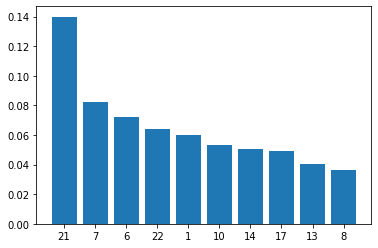

In [33]:
import matplotlib.pyplot as plt
importances = model.feature_importances_
# sort
index = np.argsort(importances)[::-1]
print("Feature Ranking")
for i in range(0, 10):
    print("(%d) %s  %f" % (index[i], dataset.columns[index[i]+2], importances[index[i]]))
plt.bar(range(10), importances[index][0:10])
plt.xticks(range(10), index)
plt.savefig(r'C:\Users\Alchemist\Documents\myProject\ppt\pictures\adaboost\imp.png')

创建并保存一个饼图，用于直观地展示特征重要性的分布情况，其中前 10 个特征各自占据一块，而其他特征的重要性合并到了 "others" 类别中。

others  0.318272
texture_worst  0.139860
concave points_mean  0.082064
concavity_mean  0.071890
perimeter_worst  0.064285
texture_mean  0.060239
radius_se  0.053412
smoothness_se  0.050678
concave points_se  0.048948
area_se  0.040702
symmetry_mean  0.036357
texture_se  0.033292


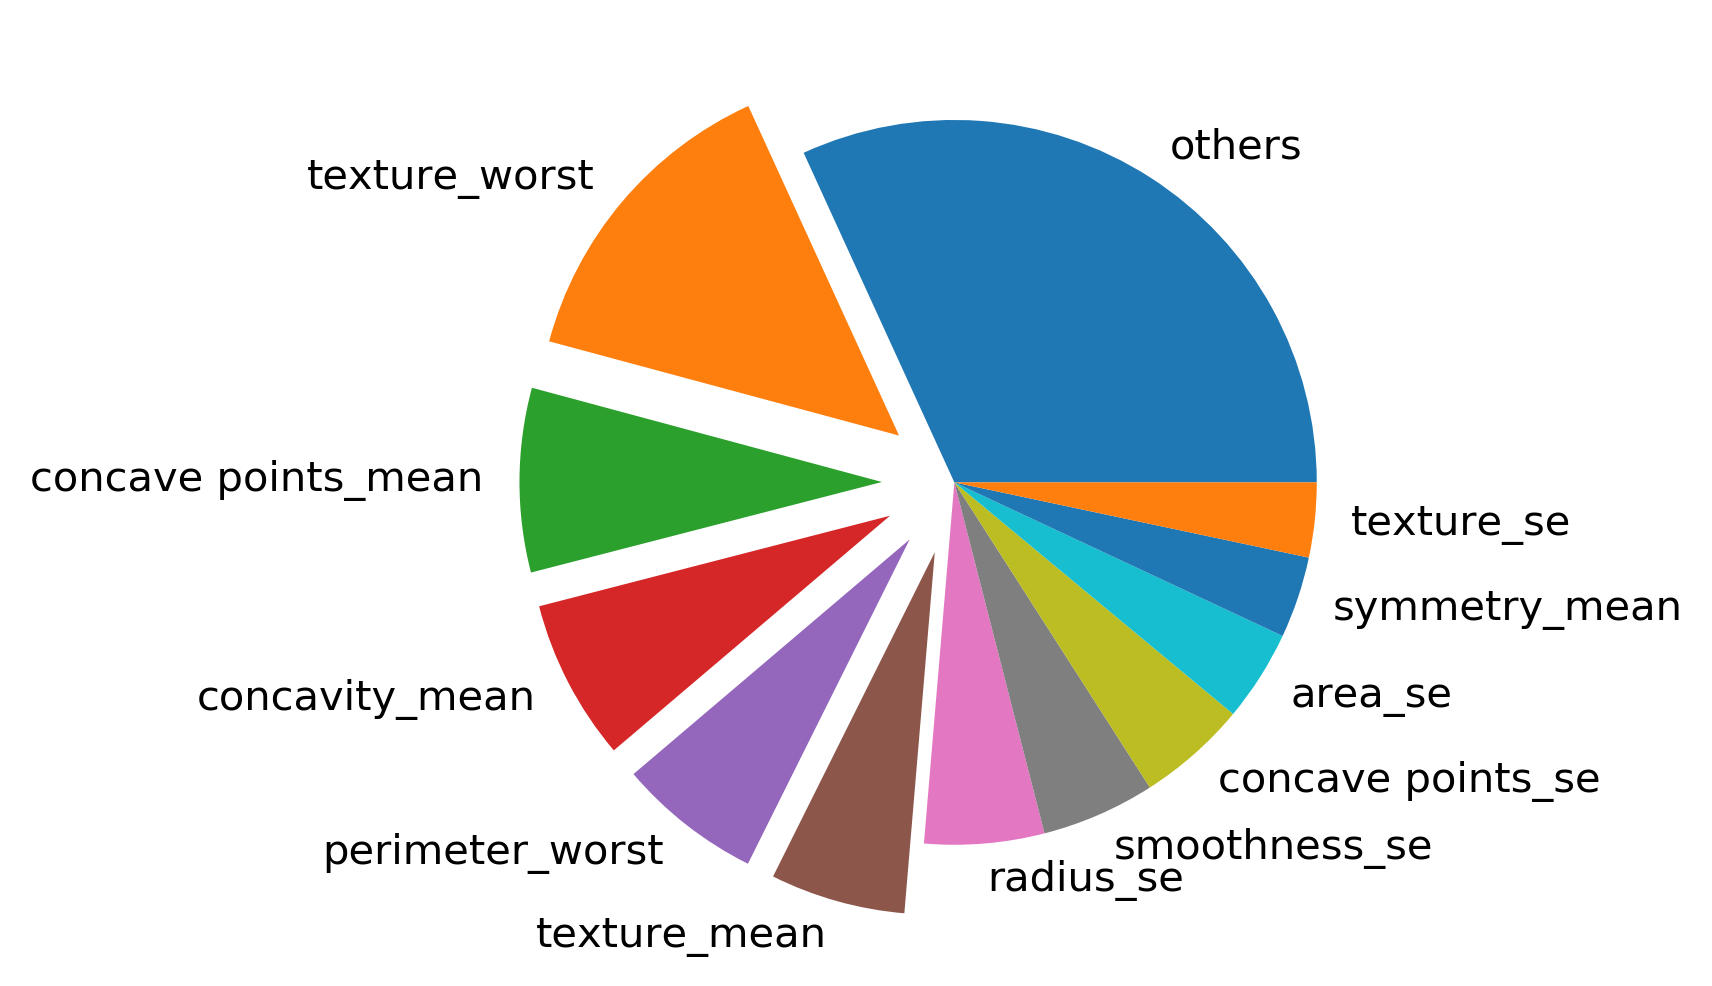

In [35]:
labels = ["others"]
values = [0]
explode = [0]
for i in range(0, 30):
    #print("(%d) %s  %f" % (index[i], dataset.columns[index[i]+2], importances[index[i]]))
    if i < 11:
        labels.append(dataset.columns[index[i]+2])
        values.append(importances[index[i]])
        if i < 5:
            explode.append(0.2)
        else:
            explode.append(0)
    else:
        values[0] = values[0] + importances[index[i]]
for i in range(12):
    print("%s  %f" % (labels[i], values[i]))
#plt.bar(range(11), values)
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.pie(values,labels=labels, explode=explode)
plt.savefig(r"C:\Users\Alchemist\Documents\myProject\ppt\pictures\adaboost\pie.png")

## 单个决策树对照
使用 sklearn 库中的决策树分类器来对给定数据集进行训练和预测，并计算模型在测试集上的准确率。

In [13]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 2, criterion = 'entropy')
clf.fit(X_train, y_train)
ans = clf.predict(X_test)
predictions = [(value) for value in ans] # float -> integer

accuracy = accuracy_score(y_test, predictions)
cnt = 0
for i in range(len(y_test)):
    if abs(ans[i] - y_test[i]) < 1e-1:
        cnt += 1
    c = (cnt / len(y_test))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.41%


## 查看训练过程

通过 AdaBoost 分类器对数据进行分类，并评估模型的准确率。

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# features and lanbels
X = dataset_data_scaled
Y = dataset_target_sm
# split data into train and test set
seed = 6
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = seed)
#fit modle on training data
model = AdaBoostClassifier()
model.fit(X_train, y_train, 
          early_stopping_rounds = 10,
          eval_set=[(X_train, y_train)],
          eval_metric='logloss',
          verbose=True) # 验证集误差迭代10次不会降低，就停止
# make predictions on test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred] # float -> integer
#evaluate
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

TypeError: fit() got an unexpected keyword argument 'early_stopping_rounds'

## n_estimators和max_depth如何影响分类效果

实现了一个简单的网格搜索算法，用于找到在给定的参数范围内，使得模型在测试数据上表现最好的参数组合。

In [13]:
from sklearn.model_selection import train_test_split

def Get_Average(list):
    sum = 0
    for num in list:
        sum += num
    avg = sum / len(list)
    return avg

accuracy = []
max_depth_test = np.arange(2, 11)
estimators_test = np.arange(2, 200, 2)
max_accuracy, best_depth, best_estimators_num = (0.0, 2, 2)
for depth in max_depth_test:
    for estimators in estimators_test:
        current = []
        for r in range(5):
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = r)
            clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth),
                                     random_state=90, n_estimators = estimators)
            clf.fit(X_train, y_train)
            ans = clf.predict(X_test)
            cnt = 0
            for i in range(len(y_test)):
                if ans[i] == y_test[i]:
                    cnt += 1
            c = cnt / len(y_test)
            current.append(c)
        avg = Get_Average(current)
        if avg > max_accuracy:
            max_accuracy = avg
            best_depth = depth
            best_estimators_num = estimators
        accuracy.append(avg)
        print("max_depth = %d  n_estimators = %d  accuracy = %f%%" % (depth, estimators, avg*100))

max_depth = 2  n_estimators = 2  accuracy = 93.426573%
max_depth = 2  n_estimators = 4  accuracy = 94.685315%
max_depth = 2  n_estimators = 6  accuracy = 95.524476%
max_depth = 2  n_estimators = 8  accuracy = 95.944056%
max_depth = 2  n_estimators = 10  accuracy = 95.804196%
max_depth = 2  n_estimators = 12  accuracy = 96.083916%
max_depth = 2  n_estimators = 14  accuracy = 95.664336%
max_depth = 2  n_estimators = 16  accuracy = 96.083916%
max_depth = 2  n_estimators = 18  accuracy = 95.804196%
max_depth = 2  n_estimators = 20  accuracy = 95.944056%
max_depth = 2  n_estimators = 22  accuracy = 96.363636%
max_depth = 2  n_estimators = 24  accuracy = 96.363636%
max_depth = 2  n_estimators = 26  accuracy = 96.503497%
max_depth = 2  n_estimators = 28  accuracy = 96.363636%
max_depth = 2  n_estimators = 30  accuracy = 95.804196%
max_depth = 2  n_estimators = 32  accuracy = 95.804196%
max_depth = 2  n_estimators = 34  accuracy = 96.083916%
max_depth = 2  n_estimators = 36  accuracy = 95.9440

max_depth = 3  n_estimators = 96  accuracy = 97.762238%
max_depth = 3  n_estimators = 98  accuracy = 97.762238%
max_depth = 3  n_estimators = 100  accuracy = 97.482517%
max_depth = 3  n_estimators = 102  accuracy = 97.482517%
max_depth = 3  n_estimators = 104  accuracy = 97.482517%
max_depth = 3  n_estimators = 106  accuracy = 97.482517%
max_depth = 3  n_estimators = 108  accuracy = 97.482517%
max_depth = 3  n_estimators = 110  accuracy = 97.622378%
max_depth = 3  n_estimators = 112  accuracy = 97.482517%
max_depth = 3  n_estimators = 114  accuracy = 97.762238%
max_depth = 3  n_estimators = 116  accuracy = 97.762238%
max_depth = 3  n_estimators = 118  accuracy = 98.041958%
max_depth = 3  n_estimators = 120  accuracy = 97.902098%
max_depth = 3  n_estimators = 122  accuracy = 97.902098%
max_depth = 3  n_estimators = 124  accuracy = 97.902098%
max_depth = 3  n_estimators = 126  accuracy = 97.902098%
max_depth = 3  n_estimators = 128  accuracy = 98.041958%
max_depth = 3  n_estimators = 130

max_depth = 4  n_estimators = 188  accuracy = 97.762238%
max_depth = 4  n_estimators = 190  accuracy = 97.622378%
max_depth = 4  n_estimators = 192  accuracy = 97.622378%
max_depth = 4  n_estimators = 194  accuracy = 97.622378%
max_depth = 4  n_estimators = 196  accuracy = 97.622378%
max_depth = 4  n_estimators = 198  accuracy = 97.622378%
max_depth = 5  n_estimators = 2  accuracy = 93.986014%
max_depth = 5  n_estimators = 4  accuracy = 94.545455%
max_depth = 5  n_estimators = 6  accuracy = 95.384615%
max_depth = 5  n_estimators = 8  accuracy = 95.524476%
max_depth = 5  n_estimators = 10  accuracy = 95.664336%
max_depth = 5  n_estimators = 12  accuracy = 95.664336%
max_depth = 5  n_estimators = 14  accuracy = 95.944056%
max_depth = 5  n_estimators = 16  accuracy = 96.083916%
max_depth = 5  n_estimators = 18  accuracy = 96.643357%
max_depth = 5  n_estimators = 20  accuracy = 96.363636%
max_depth = 5  n_estimators = 22  accuracy = 96.783217%
max_depth = 5  n_estimators = 24  accuracy = 9

max_depth = 6  n_estimators = 84  accuracy = 96.503497%
max_depth = 6  n_estimators = 86  accuracy = 96.503497%
max_depth = 6  n_estimators = 88  accuracy = 96.643357%
max_depth = 6  n_estimators = 90  accuracy = 96.643357%
max_depth = 6  n_estimators = 92  accuracy = 96.503497%
max_depth = 6  n_estimators = 94  accuracy = 96.643357%
max_depth = 6  n_estimators = 96  accuracy = 96.643357%
max_depth = 6  n_estimators = 98  accuracy = 96.503497%
max_depth = 6  n_estimators = 100  accuracy = 96.503497%
max_depth = 6  n_estimators = 102  accuracy = 96.643357%
max_depth = 6  n_estimators = 104  accuracy = 96.643357%
max_depth = 6  n_estimators = 106  accuracy = 96.643357%
max_depth = 6  n_estimators = 108  accuracy = 96.783217%
max_depth = 6  n_estimators = 110  accuracy = 96.643357%
max_depth = 6  n_estimators = 112  accuracy = 96.643357%
max_depth = 6  n_estimators = 114  accuracy = 96.643357%
max_depth = 6  n_estimators = 116  accuracy = 96.643357%
max_depth = 6  n_estimators = 118  accu

max_depth = 7  n_estimators = 180  accuracy = 95.244755%
max_depth = 7  n_estimators = 182  accuracy = 95.244755%
max_depth = 7  n_estimators = 184  accuracy = 95.244755%
max_depth = 7  n_estimators = 186  accuracy = 95.244755%
max_depth = 7  n_estimators = 188  accuracy = 95.244755%
max_depth = 7  n_estimators = 190  accuracy = 95.244755%
max_depth = 7  n_estimators = 192  accuracy = 95.244755%
max_depth = 7  n_estimators = 194  accuracy = 95.244755%
max_depth = 7  n_estimators = 196  accuracy = 95.244755%
max_depth = 7  n_estimators = 198  accuracy = 95.244755%
max_depth = 8  n_estimators = 2  accuracy = 95.244755%
max_depth = 8  n_estimators = 4  accuracy = 95.244755%
max_depth = 8  n_estimators = 6  accuracy = 95.244755%
max_depth = 8  n_estimators = 8  accuracy = 95.244755%
max_depth = 8  n_estimators = 10  accuracy = 95.244755%
max_depth = 8  n_estimators = 12  accuracy = 95.244755%
max_depth = 8  n_estimators = 14  accuracy = 95.244755%
max_depth = 8  n_estimators = 16  accuracy

## 画出折线图

(7, 99)


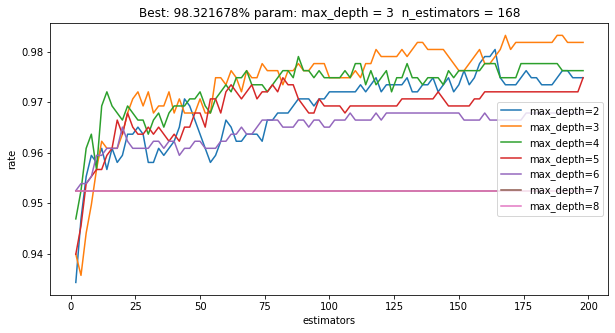

In [14]:
import matplotlib.pyplot as plt
params_values = np.zeros(len(accuracy)).reshape(len(max_depth_test), len(estimators_test))
print(params_values.shape)
for i in range(len(accuracy)):
    params_values[int(i / len(estimators_test)), int(i % len(estimators_test))] = accuracy[i]
fig = plt.figure(figsize = (10, 5))
for i in range(params_values.shape[0]):
    plt.plot(estimators_test, params_values[i], label = "max_depth=" + str(i+2))
plt.xlabel('estimators')
plt.ylabel('rate')
plt.title("Best: %f%% param: max_depth = %d  n_estimators = %d" % (max_accuracy*100, best_depth, best_estimators_num))
plt.legend(loc = 'right')

plt.savefig('C:\\Users\\Alchemist\\Documents\\myProject\\ppt\\pictures\\adaboost\\polygon1all.png')

## max_depth对分类效果的影响

通过十折交叉验证来评估 AdaBoostClassifier 模型在不同决策树最大深度下的性能，并绘制了一个图表来展示不同最大深度下模型的平均交叉验证分数。通过这个过程，可以确定最佳的决策树最大深度，以优化模型的性能。

0.9832550860719875 1


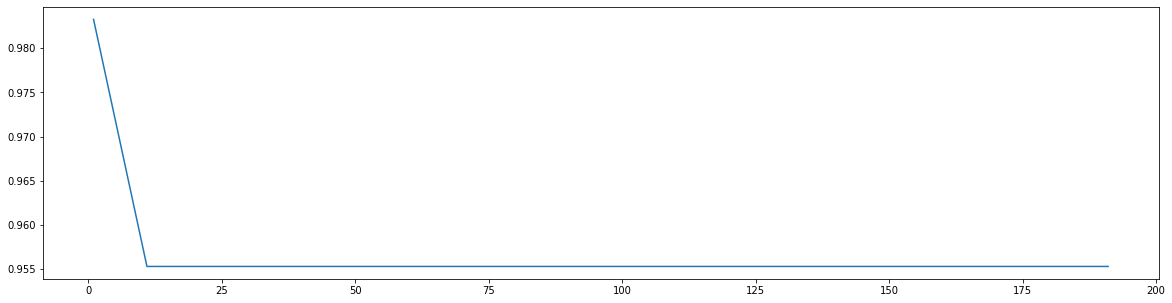

In [72]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
scorel = []
for i in range(0,200,10):
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i+1), 
                             random_state=90, n_estimators = 100)
    score = cross_val_score(clf,X,Y,cv=10).mean()#十折交叉验证取平均
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

对决策树最大深度的取值范围和步长进行了调整。展示不同最大深度下模型的平均交叉验证分数。

0.9832550860719875 1


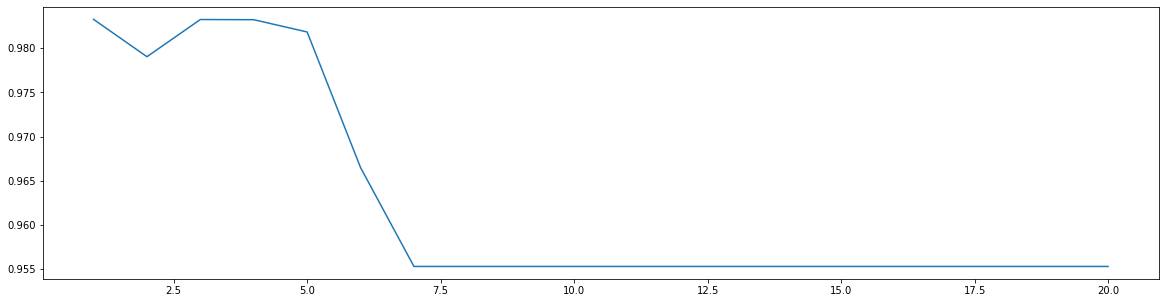

In [76]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
scorel = []
for i in range(0,20,1):
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i+1), 
                             random_state=90, n_estimators = 100)
    score = cross_val_score(clf,X,Y,cv=10).mean()#十折交叉验证取平均
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))+1))
plt.figure(figsize=[20,5])
plt.plot(range(1,21,1),scorel)
plt.show()

0.9888302034428795 71


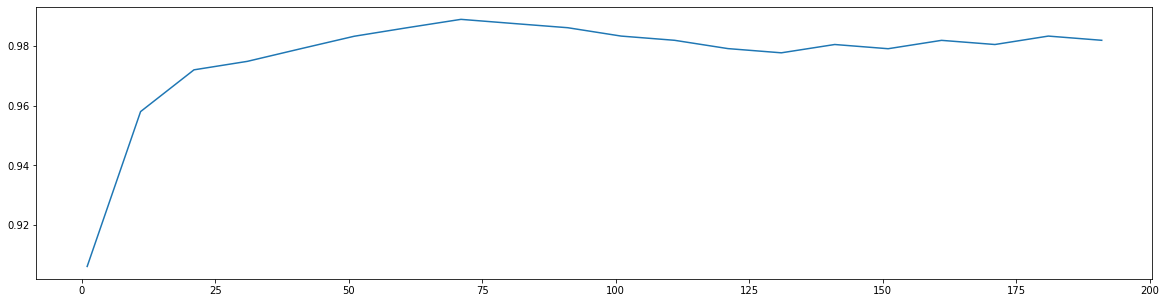

In [78]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
scorel = []
for i in range(0,200,10):
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                             random_state=90, n_estimators = i+1)
    score = cross_val_score(clf,X,Y,cv=10).mean()#十折交叉验证取平均
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

0.9888302034428795 63


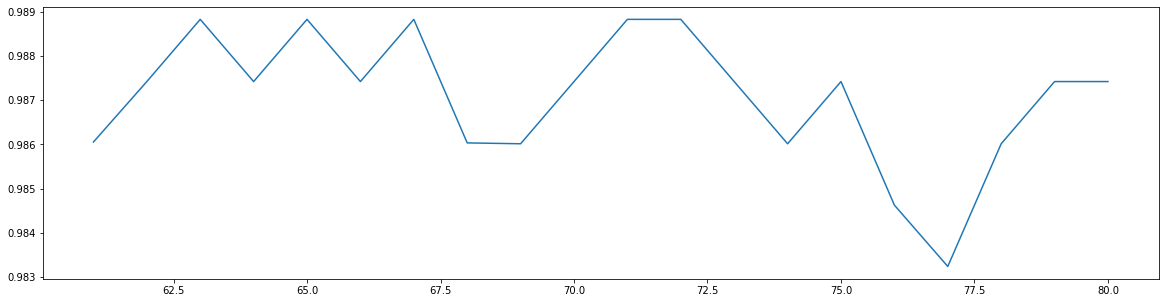

In [82]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
scorel = []
for i in range(60,80,1):
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                             random_state=90, n_estimators = i+1)
    score = cross_val_score(clf,X,Y,cv=10).mean()#十折交叉验证取平均
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))+61))
plt.figure(figsize=[20,5])
plt.plot(range(61,81,1),scorel)
plt.show()